# 协同过滤

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat

In [2]:
data = loadmat('data/ex8_movies.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 17:19:26 2011',
 '__version__': '1.0',
 '__globals__': [],
 'Y': array([[5, 4, 0, ..., 5, 0, 0],
        [3, 0, 0, ..., 0, 0, 5],
        [4, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'R': array([[1, 1, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

### Y是包含从1到5的等级的（数量的电影x数量的用户）数组.R是包含指示用户是否给电影评分的二进制值的“指示符”数组。 两者应该具有相同的维度。

In [3]:
Y = data['Y']
R = data['R']
Y.shape, R.shape

((1682, 943), (1682, 943))

In [4]:
Y[1,np.where(R[1,:]==1)[0]].mean()

3.2061068702290076

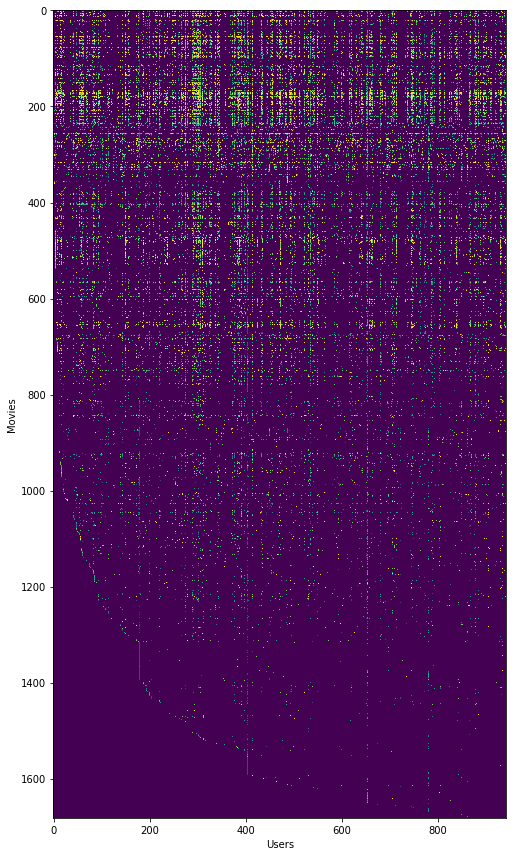

In [5]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(Y)
ax.set_xlabel('Users')
ax.set_ylabel('Movies')
fig.tight_layout()
plt.show()

## 损失函数
接下来，我们将实施协同过滤的代价函数。 直觉上，“代价”是指一组电影评级预测偏离真实预测的程度。 代价方程在练习文本中给出。 它基于文本中称为X和Theta的两组参数矩阵。 这些“展开”到“参数”输入中，以便稍后可以使用SciPy的优化包。 请注意，我已经在注释中包含数组/矩阵形状（对于我们在本练习中使用的数据），以帮助说明矩阵交互如何工作。

In [6]:
def cost(params, Y, R, num_features):
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    
    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    
    # initializations
    J = 0
    
    # compute the cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    
    return J

In [7]:
params_data = loadmat('data/ex8_movieParams.mat')
X = params_data['X']
Theta = params_data['Theta']
X.shape, Theta.shape

((1682, 10), (943, 10))

In [10]:
users = 4
movies = 5
features = 3

X_sub = X[:movies, :features]
Theta_sub = Theta[:users, :features]
Y_sub = Y[:movies, :users]
R_sub = R[:movies, :users]

params = np.concatenate((np.ravel(X_sub), np.ravel(Theta_sub)))

cost(params, Y_sub, R_sub, features)

22.224603725685675

In [15]:
def cost(params, Y, R, num_features):
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    
    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    
    # initializations
    J = 0
    X_grad = np.zeros(X.shape)  # (1682, 10)
    Theta_grad = np.zeros(Theta.shape)  # (943, 10)
    
    # compute the cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    
    # calculate the gradients
    X_grad = error * Theta
    Theta_grad = error.T * X
    
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(X_grad), np.ravel(Theta_grad)))
    
    return J, grad

In [16]:
J, grad = cost(params, Y_sub, R_sub, features)
J, grad

(22.224603725685675,
 array([ -2.52899165,   7.57570308,  -1.89979026,  -0.56819597,
          3.35265031,  -0.52339845,  -0.83240713,   4.91163297,
         -0.76677878,  -0.38358278,   2.26333698,  -0.35334048,
         -0.80378006,   4.74271842,  -0.74040871, -10.5680202 ,
          4.62776019,  -7.16004443,  -3.05099006,   1.16441367,
         -3.47410789,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ]))

## 正则化

In [18]:
def cost(params, Y, R, num_features, learning_rate):
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    
    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    
    # initializations
    J = 0
    X_grad = np.zeros(X.shape)  # (1682, 10)
    Theta_grad = np.zeros(Theta.shape)  # (943, 10)
    
    # compute the cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    
    # add the cost regularization
    J = J + ((learning_rate / 2) * np.sum(np.power(Theta, 2)))
    J = J + ((learning_rate / 2) * np.sum(np.power(X, 2)))
    
    # calculate the gradients with regularization
    X_grad = (error * Theta) + (learning_rate * X)
    Theta_grad = (error.T * X) + (learning_rate * Theta)
    
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(X_grad), np.ravel(Theta_grad)))
    
    return J, grad

In [19]:
J, grad = cost(params, Y_sub, R_sub, features, 1.5)
J, grad

(31.34405624427422,
 array([ -0.95596339,   6.97535514,  -0.10861109,   0.60308088,
          2.77421145,   0.25839822,   0.12985616,   4.0898522 ,
         -0.89247334,   0.29684395,   1.06300933,   0.66738144,
          0.60252677,   4.90185327,  -0.19747928, -10.13985478,
          2.10136256,  -6.76563628,  -2.29347024,   0.48244098,
         -2.99791422,  -0.64787484,  -0.71820673,   1.27006666,
          1.09289758,  -0.40784086,   0.49026541]))

In [26]:
movie_idx = {}
f = open('data/movie_ids.txt',encoding= 'gbk')
for line in f:
    tokens = line.split(' ')
    tokens[-1] = tokens[-1][:-1]
    movie_idx[int(tokens[0]) - 1] = ' '.join(tokens[1:])

In [27]:
movie_idx[0]

'Toy Story (1995)'

## 添加自己的评级

In [28]:
ratings = np.zeros((1682, 1))

ratings[0] = 4
ratings[6] = 3
ratings[11] = 5
ratings[53] = 4
ratings[63] = 5
ratings[65] = 3
ratings[68] = 5
ratings[97] = 2
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5

print('Rated {0} with {1} stars.'.format(movie_idx[0], str(int(ratings[0]))))
print('Rated {0} with {1} stars.'.format(movie_idx[6], str(int(ratings[6]))))
print('Rated {0} with {1} stars.'.format(movie_idx[11], str(int(ratings[11]))))
print('Rated {0} with {1} stars.'.format(movie_idx[53], str(int(ratings[53]))))
print('Rated {0} with {1} stars.'.format(movie_idx[63], str(int(ratings[63]))))
print('Rated {0} with {1} stars.'.format(movie_idx[65], str(int(ratings[65]))))
print('Rated {0} with {1} stars.'.format(movie_idx[68], str(int(ratings[68]))))
print('Rated {0} with {1} stars.'.format(movie_idx[97], str(int(ratings[97]))))
print('Rated {0} with {1} stars.'.format(movie_idx[182], str(int(ratings[182]))))
print('Rated {0} with {1} stars.'.format(movie_idx[225], str(int(ratings[225]))))
print('Rated {0} with {1} stars.'.format(movie_idx[354], str(int(ratings[354]))))

Rated Toy Story (1995) with 4 stars.
Rated Twelve Monkeys (1995) with 3 stars.
Rated Usual Suspects, The (1995) with 5 stars.
Rated Outbreak (1995) with 4 stars.
Rated Shawshank Redemption, The (1994) with 5 stars.
Rated While You Were Sleeping (1995) with 3 stars.
Rated Forrest Gump (1994) with 5 stars.
Rated Silence of the Lambs, The (1991) with 2 stars.
Rated Alien (1979) with 4 stars.
Rated Die Hard 2 (1990) with 5 stars.
Rated Sphere (1998) with 5 stars.


In [29]:
R = data['R']
Y = data['Y']

Y = np.append(Y, ratings, axis=1)
R = np.append(R, ratings != 0, axis=1)

Y.shape, R.shape, ratings.shape

((1682, 944), (1682, 944), (1682, 1))

## 随机初始化参数

In [33]:
movies = Y.shape[0]  # 1682
users = Y.shape[1]  # 944
features = 10
learning_rate = 10.

X = np.random.random(size=(movies, features))
Theta = np.random.random(size=(users, features))
params = np.concatenate((np.ravel(X), np.ravel(Theta)))

X.shape, Theta.shape, params.shape

((1682, 10), (944, 10), (26260,))

In [34]:
Ymean = np.zeros((movies, 1))
Ynorm = np.zeros((movies, users))

for i in range(movies):
    idx = np.where(R[i,:] == 1)[0]
    Ymean[i] = Y[i,idx].mean()
    Ynorm[i,idx] = Y[i,idx] - Ymean[i]

Ynorm.mean()

5.507036456515984e-19

In [40]:
from scipy.optimize import minimize

fmin = minimize(fun=cost, x0=params, args=(Ynorm, R, features, learning_rate), 
                method='CG', jac=True, options={'maxiter': 100})
fmin

     fun: 38952.32141560198
     jac: array([ 0.06205364, -0.06087548, -0.0064376 , ..., -0.00046158,
       -0.00173997,  0.00139559])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 147
     nit: 100
    njev: 147
  status: 1
 success: False
       x: array([-0.18379108,  0.41189287,  0.59222182, ...,  0.23673689,
        0.07268772, -0.1182556 ])

In [41]:
X = np.matrix(np.reshape(fmin.x[:movies * features], (movies, features)))
Theta = np.matrix(np.reshape(fmin.x[movies * features:], (users, features)))

X.shape, Theta.shape

((1682, 10), (944, 10))

In [42]:
predictions = X * Theta.T 
my_preds = predictions[:, -1] + Ymean
my_preds.shape

(1682, 1)

In [47]:
sorted_preds = np.sort(my_preds, axis=0)[::-1]
sorted_preds[:10]

matrix([[5.00000022],
        [5.00000008],
        [4.99999996],
        [4.9999999 ],
        [4.99999989],
        [4.99999986],
        [4.99999984],
        [4.99999979],
        [4.99999952],
        [4.99999943]])

In [48]:
idx = np.argsort(my_preds, axis=0)[::-1]
idx

matrix([[1200],
        [1188],
        [1652],
        ...,
        [ 438],
        [1431],
        [ 436]])

In [49]:
print("Top 10 movie predictions:")
for i in range(10):
    j = int(idx[i])
    print('Predicted rating of {0} for movie {1}.'.format(str(float(my_preds[j])), movie_idx[j]))

Top 10 movie predictions:
Predicted rating of 5.000000224867459 for movie Marlene Dietrich: Shadow and Light (1996) .
Predicted rating of 5.0000000835874285 for movie Prefontaine (1997).
Predicted rating of 4.999999955200104 for movie Entertaining Angels: The Dorothy Day Story (1996).
Predicted rating of 4.99999989727043 for movie Santa with Muscles (1996).
Predicted rating of 4.999999893256503 for movie They Made Me a Criminal (1939).
Predicted rating of 4.9999998579577705 for movie Aiqing wansui (1994).
Predicted rating of 4.9999998445290155 for movie Someone Else's America (1995).
Predicted rating of 4.99999979089327 for movie Saint of Fort Washington, The (1993).
Predicted rating of 4.999999520476469 for movie Star Kid (1997).
Predicted rating of 4.9999994273146156 for movie Great Day in Harlem, A (1994).
